In [1]:

library(causalTree)
library(grf)
library(rpart)
library(glmnet)
library(splines)
library(MASS)
library(lmtest)
library(sandwich)
library(ggplot2)

Loading required package: rpart
Loading required package: rpart.plot
Loading required package: data.table
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [2]:
library(causalTree)


In [2]:
## loading the data
data <- as.data.frame(read.table("C:/Users/JOSE/Documents/GitHub/ECO224/Labs/data/penn_jae.dat", header=T ))

data<- subset(data, tg== 4| tg==0)


In [3]:
data<- subset(data, tg== 4| tg==0)


In [4]:
T4 <- (data$tg==4)


In [5]:
# Only valid in randomized settings

#
m <- lm(log(inuidur1)~female*T4, data=data)
library(lmtest)
library(sandwich)
coeftest(m, vcov=vcovHC(m, type='HC2'))






t test of coefficients:

               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.022391   0.026987 74.9392  < 2e-16 ***
female         0.084995   0.042787  1.9864  0.04704 *  
T4TRUE        -0.115695   0.046284 -2.4997  0.01246 *  
female:T4TRUE  0.076010   0.073048  1.0405  0.29814    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


There is no significant heterogeneous effect on T4

Causal Trees

In [6]:
# Only valid for randomized data!

fmla  <- 'log(inuidur1) ~ (female+black+othrace+factor(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)'


In [7]:
treatment <- "tg"

In [8]:
# Dividing data into three subsets
# Dividimos en 3 grandes subgrupos: hago todo el proceso de optimizar árbol ideal, 
# con el árbol ideal busco mis efectos heterogéneos con los datos de estimación
# Con lo q encuentro el paso previo testeo con la data test
indices <- split(seq(nrow(data)), sort(seq(nrow(data)) %% 3))
names(indices) <- c('split', 'est', 'test')

## Explain why we need to partitionate the data in three sets. 

It is divided into 3 large subgroups split, estimation, test. In split look for the process of estimating the ideal optimized tree. With the found tree I look for my heterogeneous effects but using the estimation data.And finally test. 


In [41]:
data$tg


[1] 0 0 0 4 0 0 0 0 0 0 0 4 0 0 4 0 0 0 0 0 0 4 0 0 4 4 4 0 0 4 0 0 4 0 4 0 0
  [38] 0 0 4 0 0 0 4 0 0 0 4 4 4 0 0 0 0 0 4 0 0 4 0 0 4 0 4 0 0 4 0 4 0 0 0 0 0
  [75] 0 0 0 0 0 4 4 4 4 0 0 0 0 4 4 0 4 0 0 0 4 4 0 0 0 0 4 0 0 4 0 0 0 4 4 0 0
 [112] 0 0 0 4 0 0 0 4 0 0 0 0 0 0 4 4 4 0 0 0 0 0 4 4 0 0 0 0 0 4 0 4 4 4 0 4 0
 [149] 0 0 0 0 0 0 0 0 0 4 0 0 0 4 4 0 0 0 0 4 4 4 0 4 0 0 0 4 0 0 0 0 0 0 0 0 0
 [186] 0 0 0 0 0 0 4 0 0 0 0 0 4 4 0 0 4 4 0 0 0 4 0 0 0 0 0 0 0 0 0 4 0 0 4 0 0
 [223] 0 0 0 0 4 0 0 4 0 0 0 4 4 0 4 0 0 0 0 4 0 0 4 0 0 0 4 4 0 0 0 0 0 0 0 0 0
 [260] 0 0 0 4 0 0 4 0 0 0 4 0 4 0 4 4 0 4 0 4 0 0 0 0 4 4 0 4 0 0 0 0 4 0 0 0 0
 [297] 0 4 4 0 0 0 4 0 0 4 4 0 0 0 0 0 4 0 4 4 0 0 0 4 0 4 0 0 4 0 4 0 0 0 0 0 0
 [334] 0 0 4 4 4 0 4 0 0 0 0 0 0 0 0 4 0 4 0 0 0 4 4 0 0 0 0 4 0 4 4 4 4 4 0 0 0
 [371] 4 0 0 0 0 0 4 0 0 4 0 0 0 4 4 4 4 4 4 0 0 0 0 0 0 0 0 4 4 0 0 0 4 4 0 0 0
 [408] 4 0 4 4 0 0 4 0 4 4 0 0 0 0 0 0 4 0 0 0 4 0 4 0 0 0 0 0 0 0 0 4 0 4 0 4 0
 [445] 4 0 0 4 4 0 4 0 0 4 0 0 4 0 0 0 4 0 0 0 0 0 0 0 4 0 0 4 0 0 0 4 0 0 0 0 4
 [482] 4 0 0 0 4 0 0 0 4 4 4 0 4 4 4 0 0 0 4 0 0 4 0 0 4 4 4 4 0 0 0 4 0 4 0 4 4
 [519] 0 0 4 4 0 0 0 0 0 0 4 0 0 4 0 0 0 4 4 4 4 0 0 4 0 0 0 4 4 4 0 4 4 0 4 0 4
 [556] 0 4 0 0 4 0 0 4 0 0 0 0 0 4 0 4 0 0 0 0 0 4 4 4 4 4 4 0 4 0 0 0 4 0 0 0 0
 [593] 4 4 0 4 4 0 0 0 0 4 0 4 4 0 0 4 4 4 0 0 4 0 4 4 4 0 0 4 4 0 0 4 0 4 0 4 4
 [630] 4 4 0 0 0 4 4 4 4 0 4 0 0 0 0 0 0 4 4 4 0 0 0 0 0 4 0 0 4 4 0 4 0 0 4 4 0
 [667] 0 4 4 0 0 0 0 0 0 4 4 0 0 4 0 0 4 4 0 0 0 0 0 0 4 0 0 0 4 0 0 4 4 0 0 0 0
 [704] 0 0 0 0 0 0 4 4 4 0 0 4 0 4 0 0 0 0 4 0 0 4 0 0 0 0 0 4 0 0 0 0 0 4 0 0 0
 [741] 0 0 0 0 0 0 0 0 0 4 0 0 4 0 4 0 0 0 0 0 0 4 0 4 0 0 0 0 0 0 0 4 0 4 0 0 0
 [778] 0 0 0 0 4 0 0 0 4 0 0 0 0 0 0 4 0 0 0 4 0 0 0 0 0 0 0 4 4 4 4 0 0 4 0 4 0
 [815] 0 0 4 0 4 4 0 0 4 4 4 4 0 0 0 4 4 4 0 0 0 0 4 0 0 0 0 4 0 0 0 4 0 0 0 4 0
 [852] 0 4 0 0 4 4 0 0 0 4 4 0 0 4 0 4 0 0 0 0 4 4 0 0 0 4 0 4 4 0 4 0 4 0 0 0 4
 [889] 4 4 0 0 0 0 4 4 0 0 4 0 0 4 0 4 4 0 4 0 0 0 0 4 4 4 0 4 0 0 0 0 0 4 0 0 0
 [926] 4 0 0 4 0 4 0 0 4 4 0 0 4 4 0 0 0 4 0 0 4 0 0 0 0 0 0 0 4 4 0 0 0 0 4 4 4
 [963] 0 0 0 0 4 0 0 0 0 0 0 0 4 0 0 0 0 0 4 0 0 0 0 4 0 4 0 4 0 0 0 0 4 0 4 4 0
[1000] 0 4 4 4 0 4 4 0 0 0 0 4 0 4 0 0 0 4 0 0 0 0 4 4 0 0 4 4 4 0 0 0 0 4 0 4 0
[1037] 4 4 0 4 0 4 4 0 0 0 0 0 4 0 4 4 0 0 4 4 0 0 0 4 0 4 0 4 0 4 4 0 4 0 0 4 0
[1074] 0 0 0 0 0 0 4 0 0 0 4 4 4 0 0 0 0 4 0 0 0 0 0 0 0 4 4 0 4 0 4 4 0 0 4 0 0
[1111] 4 4 4 0 0 0 0 0 0 0 0 4 0 0 0 4 4 4 0 0 0 4 4 4 4 4 0 0 0 4 4 0 0 0 0 4 0
[1148] 0 0 0 4 0 0 0 0 4 0 0 0 0 0 4 0 4 0 0 4 4 4 4 0 0 0 0 0 0 4 4 4 4 0 4 0 0
[1185] 0 0 0 0 4 0 0 0 4 4 4 4 4 0 0 0 0 0 0 0 0 4 0 0 4 4 0 4 4 4 4 0 4 0 4 0 4
[1222] 0 4 0 0 0 0 0 0 0 4 0 0 4 0 0 0 4 4 0 0 0 4 0 0 0 0 4 4 4 0 4 0 0 0 0 0 4
[1259] 0 0 4 0 0 0 0 0 0 0 4 4 0 4 4 4 0 0 0 0 0 4 0 0 4 4 4 4 0 4 4 4 0 0 4 0 0
[1296] 4 0 0 0 0 0 0 0 4 4 0 0 0 4 4 4 0 0 4 4 0 0 0 0 0 0 4 0 0 0 4 4 0 0 0 0 0
[1333] 4 4 0 0 4 0 4 0 4 0 0 4 4 0 4 0 0 0 0 4 4 0 0 0 0 4 0 4 0 0 0 0 0 4 4 0 0
[1370] 0 0 4 4 4 0 4 0 0 0 4 0 0 0 0 0 0 4 0 0 0 4 0 4 4 0 0 4 0 0 0 0 0 4 4 4 0
[1407] 4 0 0 0 0 0 4 0 4 0 0 0 0 4 0 0 0 0 4 0 0 4 4 4 0 0 0 0 0 4 4 4 4 0 4 0 0
[1444] 4 4 4 0 0 4 4 0 0 4 4 0 4 0 0 4 4 0 0 0 4 0 4 0 0 4 4 4 0 4 4 4 4 4 0 0 0
[1481] 0 4 4 0 4 0 0 0 0 4 0 0 0 0 0 4 4 4 0 4 0 4 4 4 0 4 0 0 4 4 0 4 0 0 0 4 4
[1518] 0 0 0 0 4 0 0 4 0 4 0 0 0 0 0 0 4 0 4 4 0 4 0 0 4 4 0 0 0 0 0 4 0 0 0 0 4
[1555] 0 4 0 0 0 0 0 0 0 4 0 4 4 4 4 0 0 4 0 0 0 4 0 0 0 4 4 0 4 4 0 0 4 0 0 0 0
[1592] 4 0 0 4 4 0 4 4 0 0 0 4 4 4 4 0 0 4 0 0 4 0 0 4 0 0 0 0 0 0 0 0 0 0 4 0 0
[1629] 0 0 0 4 4 0 4 0 0 0 0 4 0 4 0 0 0 0 0 0 0 0 0 0 0 4 4 0 0 0 0 0 0 4 0 4 0
[1666] 4 4 4 0 4 4 4 0 0 0 0 0 0 0 0 0 0 0 4 4 4 0 0 0 0 4 0 4 4 0 4 4 0 0 4 0 4
[1703] 0 0 4 0 4 0 4 0 0 4 0 0 0 4 0 0 4 0 0 4 0 0 0 0 4 4 0 0 4 0 0 4 0 0 0 4 0
[1740] 4 0 4 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 4 0 4 0 4 4 4 0 0 0 0 0 4 0 4 0 0 0 0
[1777] 0 0 0 4 0 0 0 0 0 0 4 4 0 0 4 0 0 0 0 0 0 4 0 0 4 0 0 4 4 0 0 0 0 0 0 0 4
[1814] 0 0 4 0 0 4 4 4 4 0 4 0 0 0

 ### Why do we need to use the honest.causalTree function? 
 
It works with honesty because the adaptive uses the estimation data and split to find the heterogeneous effects. But it is not efficient to reach an overfiiting and finds average above. On the other hand, honestly, the average is much tighter.

 ## Explain in detail the creation of the tree and how do you choose the optimal pruned tree 
 
First the model is defined and the data split is used. A statistic of the data is assembled and minimized.

In [9]:
data$tg<-replace(data$tg, data$tg>0,1)

In [10]:
# Fitting the forest
ct.unpruned <- honest.causalTree(
  formula=fmla,            # Define the model
  data=data[indices$split,],
  treatment=data[indices$split, treatment],
  est_data=data[indices$est,],
  est_treatment=data[indices$est, treatment],
  minsize=1,                 # Min. number of treatment and control cases in each leaf
  HonestSampleSize=length(indices$est), #  Num obs used in estimation after splitting
  
  # We recommend not changing the parameters below
  split.Rule="CT",            # Define the splitting option
  cv.option="TOT",            # Cross validation options
  cp=0,                       # Complexity parameter
  split.Honest=TRUE,          # Use honesty when splitting
  cv.Honest=TRUE              # Use honesty when performing cross-validation
)

[1] 2
[1] "CT"


In [16]:
# Table of cross-validated values by tuning parameter.
ct.cptable <- as.data.frame(ct.unpruned$cptable)
ct.cptable

CP,nsplit,rel error,xerror,xstd
6.855904e-05,0,1.0000000,1.0000000,0.01069721
6.803866e-05,2,0.9998629,0.9991121,0.01069065
6.529121e-05,7,0.9994797,0.9991121,0.01069065
6.379281e-05,8,0.9994144,0.9991121,0.01069065
6.160760e-05,9,0.9993506,0.9989697,0.01068220
4.082282e-05,11,0.9992274,0.9985733,0.01068690
2.543308e-05,12,0.9991865,0.9994294,0.01069442
2.459487e-05,13,0.9991611,1.0006939,0.01070747
1.502619e-05,14,0.9991365,0.9998509,0.01070053
8.296428e-06,15,0.9991215,1.0000310,0.01069923


In [19]:
# Obtain optimal complexity parameter to prune tree.
cp.selected <- which.min(ct.cptable$xerror)
cp.selected

[1] 6

In [20]:
cp.optimal <- ct.cptable[cp.selected, "CP"]

# Prune the tree at optimal complexity parameter.
ct.pruned <- prune(tree=ct.unpruned, cp=cp.optimal)

In [21]:
# Predict point estimates (on estimation sample)
tau.hat.est <- predict(ct.pruned, newdata=data[indices$est,])

# Create a factor column 'leaf' indicating leaf assignment in the estimation set
num.leaves <- length(unique(tau.hat.est))
leaf <- factor(tau.hat.est, levels=sort(unique(tau.hat.est)), labels = seq(num.leaves))

## Plot the pruned tree and explain the HTE you found.

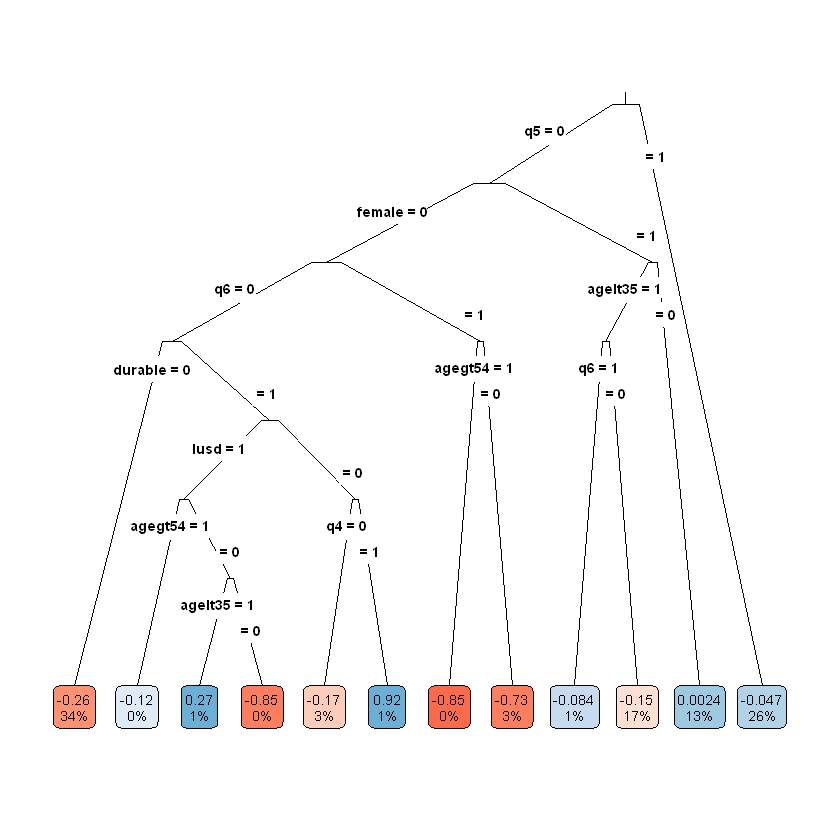

In [23]:
rpart.plot(
  x=ct.pruned,        # Pruned tree
  type=3,             # Draw separate split labels for the left and right directions
  fallen=TRUE,        # Position the leaf nodes at the bottom of the graph
  leaf.round=1,       # Rounding of the corners of the leaf node boxes
  extra=100,          # Display the percentage of observations in the node
  branch=.1,          # Shape of the branch lines
  box.palette="RdBu") # Palette for coloring the node

In the first branch, the tree divides whether it belongs to quartile 5 or not, if it does, the probability that the treatment effect is -0.047 is 26%.
If 0 is divided for the female variable, if it is not a woman, it will be chosen if agelt35 (it is less than 35) is not selected, then the probability of the treatment effect is 0.0024 is 13%.